In [1]:
# Autor: Elvis do A. Soares
# Github: @elvissoares
from sys import stdout
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# OPLS

OPLS (Optimized Potentials for Liquid Simulations)


A forma funcional do OPLS:

$$E \left(r^N \right ) = E_\mathrm{bonds} + E_\mathrm{angles} + E_\mathrm{dihedrals} + E_\mathrm{nonbonded}$$

$$E_\mathrm{bonds} = \sum_\mathrm{bonds} K_r (r-r_0)^2 \, $$

$$E_\mathrm{angles} = \sum_\mathrm{angles} k_\theta (\theta-\theta_0)^2 \, $$

$$E_\mathrm{dihedrals} = \sum_\mathrm{dihedrals} \left( \frac {V_1} {2} \left [ 1 + \cos (\phi-\phi_1) \right ] 
                + \frac {V_2} {2} \left [ 1 - \cos (2\phi-\phi_2) \right ] 
                + \frac {V_3} {2} \left [ 1 + \cos (3\phi-\phi_3) \right ] 
                + \frac {V_4} {2} \left [ 1 - \cos (4\phi-\phi_4) \right ] \right)$$

$$E_\mathrm{nonbonded} = \sum_{i>j} f_{ij} \left(
                    \frac {A_{ij}}{r_{ij}^{12}} - \frac {C_{ij}}{r_{ij}^6}
                    + \frac {q_iq_j e^2}{4\pi\epsilon_0 r_{ij}} \right) $$

com a regra de combinação geométrica $A_{ij} = \sqrt{A_{ii} A_{jj}}$ e  $C_{ij} = \sqrt{C_{ii}C_{jj}}$.

- Interações intramoleculares não-ligantes $E_\mathrm{nonbonded}$ são levadas em conta somente para os átomos que estão de três ou mais ligações distantes. 

- Interações entre partículas 1 e 4, 5, 6,... são escaladas por um fator $f_{ij} = 0.5$. As demais tem fator $f_{ij} = 1.0$.


### Referências:

- Jorgensen WL, Tirado-Rives J (1988). "The OPLS Force Field for Proteins. Energy Minimizations for Crystals of Cyclic Peptides and Crambin". J. Am. Chem. Soc. 110 (6): 1657–1666. doi:10.1021/ja00214a001
- Jorgensen WL, Maxwell DS, Tirado-Rives J (1996). "Development and Testing of the OPLS All-Atom Force Field on Conformational Energetics and Properties of Organic Liquids". J. Am. Chem. Soc. 118 (45): 11225–11236. doi:10.1021/ja9621760.


In [2]:
import mdtraj
import nglview

from openmm.app import *
from openmm import *
from openmm.unit import *

Qual molécula iremos simular?

In [4]:
my_molecule = 'caffeine'

Condição termodinâmica

In [4]:
Temperatura = 298.15 * kelvin # Temperatura em Kelvin
Pressao = 1 * bar # Pressão em bar

Lendo arquivo pdb gerado pelo LibParGen para OPLS

LibParGen: https://traken.chem.yale.edu/ligpargen/index.html

In [5]:
pdb = PDBFile(f'{my_molecule}.pdb')

Escolhendo os arquivos de campo de força OPLS-AA gerados pelo LibParGen

In [6]:
forcefield = ForceField(f'{my_molecule}.xml', 'tip3p.xml')
forcefield.setUseGeometricCombinationRule=True # OPLS-AA usa combinação geométrica

Cria a topolgia com moléculas de água ao redor (solvente)

In [7]:
modeller = Modeller(pdb.topology, pdb.positions)

modeller.addSolvent(forcefield,model='tip3p', boxSize=Vec3(3.0, 3.0, 3.0)*nanometers)

PDBFile.writeFile(modeller.topology, modeller.positions, open(f'initial_{my_molecule}.pdb', 'w'))

In [8]:
# Mostra molécula dentro do NGLView
view = nglview.show_mdtraj(mdtraj.load(f'initial_{my_molecule}.pdb'), width='600px', height='400px')
view.clear_representations()
view.add_ball_and_stick()
# view.add_representation('licorice', selection='not water')
# view.add_representation('spacefill', selection='water')
# centraliza a visualização de toda a caixa de simulação
view.center(selection='all') # centraliza
view.add_unitcell()
view 

NGLWidget()

In [9]:
system = forcefield.createSystem(modeller.topology, nonbondedMethod=PME,
        nonbondedCutoff=1*nanometer, constraints=None)

# Plataforma (GPU se disponível)
platform = Platform.getPlatformByName('CUDA') if 'CUDA' in [Platform.getPlatform(i).getName() for i in range(Platform.getNumPlatforms())] else Platform.getPlatformByName('CPU')
# Integrador
integrator = LangevinMiddleIntegrator(300*kelvin, 1/picosecond, 1*femtoseconds)

simulation = Simulation(modeller.topology, system, integrator,platform)
simulation.context.setPositions(modeller.positions)

Minimizando a energia

In [10]:
simulation.minimizeEnergy()

energy = simulation.context.getState(getEnergy=True).getPotentialEnergy()
print(f'Energia: {energy}')


Energia: -43339.208458683774 kJ/mol


Definindo os relatórios

In [11]:
# Remove reporters existentes, no caso dessa célula ser executada mais de uma vez.
simulation.reporters = []

# Escreve cada frame em arquivo DCD de trajetórias a cada 200 passos
simulation.reporters.append(DCDReporter(f"output_{my_molecule}.dcd", 100))

# Escreve num arquivo csv a cada 20 passos 
simulation.reporters.append(
    StateDataReporter(
        f"md_log_{my_molecule}.csv",
        100,
        step=True,
        time=True,
        potentialEnergy=True,
        totalEnergy=True,
        temperature=True,
        volume=True
    )
)

# Escreve na tela a cada 1000 passos 
simulation.reporters.append(
    StateDataReporter(stdout, 1000, step=True, totalEnergy=True,temperature=True,
        volume=True)
)

## Equilibração NVT

In [12]:
simulation.context.setVelocitiesToTemperature(Temperatura)

simulation.step(5000)

#"Step","Total Energy (kJ/mole)","Temperature (K)","Box Volume (nm^3)"
1000,-32423.672445535514,240.36764632985444,27.0
2000,-30559.17984414645,256.8032238516065,27.0
3000,-29331.688506083883,276.77987411638065,27.0
4000,-28664.792022455338,292.2550753455827,27.0
5000,-28358.98152006566,295.49850127354983,27.0


## Produção NPT

In [13]:
system.addForce(MonteCarloBarostat(Pressao, Temperatura))
simulation.context.reinitialize(preserveState=True)


print("Running NPT")
simulation.step(100_000)

# A próxima linha é necessária para Windows para fechar os arquivos antes de serem abertos
del simulation

Running NPT
6000,-28316.439223359106,302.1250969999227,26.356251473142716
7000,-28422.883916611056,294.6200273013956,26.20452927205239
8000,-28315.623819839064,302.1732493596045,26.065136096198064
9000,-28501.079218965926,290.1548268283366,26.05591244727366
10000,-27989.266715968784,307.59873455583437,26.371207498311932
11000,-27842.458568526577,308.31640420916517,26.06916524277067
12000,-27778.41053587565,304.07477689158634,26.50866882913278
13000,-27825.5256601983,299.808682111936,26.3361362762237
14000,-27933.081697207846,299.46702807447053,26.242328522116882
15000,-28552.373720598902,296.85652061823356,26.108206567922586
16000,-28515.535758343205,294.8712844589397,26.001591525734376
17000,-28137.923374299455,298.6648850535182,26.715161034897886
18000,-27862.225383498968,303.1103758326038,26.31410413649864
19000,-28054.35420092783,299.400498300761,26.353369268900682
20000,-28231.970500126772,299.5558846571728,26.268601452936366
21000,-28108.5604236309,299.56617470462044,26.255400040

## Visualizando a Simulação

In [5]:
traj = mdtraj.load(f"output_{my_molecule}.dcd", top=f"initial_{my_molecule}.pdb")
view = nglview.show_mdtraj(traj, width='600px', height='400px')
view.clear_representations()
view.add_unitcell()
view.add_ball_and_stick(selection='not water')
#centralizado
view.center(selection='not water') # centraliza
view

NGLWidget(max_frame=1049)

## Analisando a estatística dos dados

In [6]:
df = pd.read_csv(f"md_log_{my_molecule}.csv")

In [7]:
df.head()

,"#""Step""",Time (ps),Potential Energy (kJ/mole),Total Energy (kJ/mole),Temperature (K),Box Volume (nm^3)
0,100,0.1,-39490.298669,-36205.490416,151.455482,27.0
1,200,0.2,-39180.262597,-35559.768075,166.933258,27.0
2,300,0.3,-38982.732201,-35183.934167,175.154451,27.0
3,400,0.4,-38741.177026,-34527.689654,194.274889,27.0
4,500,0.5,-38485.402428,-34056.144049,204.223629,27.0


In [8]:
df['Total Energy (kJ/mole)']

0      -36205.490416
1      -35559.768075
2      -35183.934167
3      -34527.689654
4      -34056.144049
            ...     
1045   -27723.686251
1046   -27714.186089
1047   -27703.482854
1048   -27742.045654
1049   -27771.652782
Name: Total Energy (kJ/mole), Length: 1050, dtype: float64

Text(0, 0.5, 'Volume (nm$^3$)')

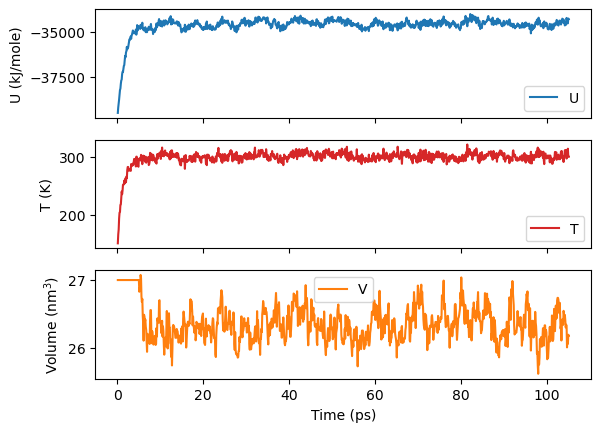

In [9]:
fig, axs = plt.subplots(3, 1, sharex=True)

axs[0].plot(df['Time (ps)'],df['Potential Energy (kJ/mole)'],color='C0',label='U')
axs[0].legend(loc='best')
axs[0].set_ylabel('U (kJ/mole)')

axs[1].plot(df['Time (ps)'],df['Temperature (K)'],color='C3',label='T')
axs[1].legend(loc='best')
axs[1].set_ylabel('T (K)')

axs[2].plot(df['Time (ps)'],df['Box Volume (nm^3)'],color='C1',label='V')
axs[2].legend(loc='best')
axs[2].set_xlabel('Time (ps)')
axs[2].set_ylabel('Volume (nm$^3$)')

In [10]:
timecut = 10
subsetT = df['Temperature (K)'][df['Time (ps)'] > timecut]
subsetU = df['Potential Energy (kJ/mole)'][df['Time (ps)'] > timecut]
subsetV = df['Box Volume (nm^3)'][df['Time (ps)'] > timecut]

In [11]:
from IPython.display import display, Math

Umean = subsetU.mean()
sigmaU = subsetU.std()

display(Math(rf"U = {Umean:.2f} \pm {sigmaU:.2f}\ kJ/mole"))

<IPython.core.display.Math object>

In [12]:
Tmean = subsetT.mean()
sigmaT = subsetT.std()

display(Math(rf"$T = {Tmean:.2f} \pm {sigmaT:.2f}\ K"))

<IPython.core.display.Math object>

In [13]:
Vmean = subsetV.mean()
sigmaV = subsetV.std()

display(Math(rf"$V = {Vmean:.2f} \pm {sigmaV:.2f}\ nm^3"))

<IPython.core.display.Math object>

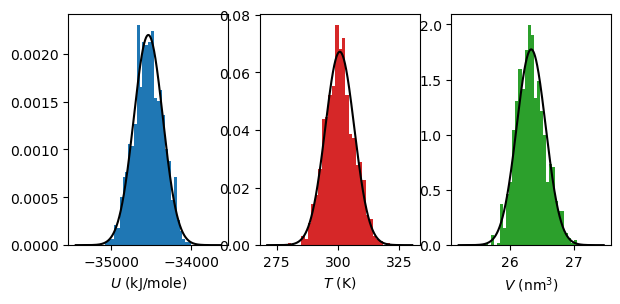

In [14]:
fig, axs = plt.subplots(1, 3,figsize=(7,3))

axs[0].hist(subsetU,bins=30,density=True)
axs[0].set_xlabel(r'$U$ (kJ/mole)')

uarray = Umean+np.arange(-5*sigmaU,5*sigmaU,0.01*sigmaU)
axs[0].plot(uarray,np.sqrt(1/(2*np.pi*sigmaU**2))*np.exp(-0.5*(uarray-Umean)**2/sigmaU**2),color='k')

axs[1].hist(subsetT,bins=30,density=True,color='C3')
axs[1].set_xlabel(r'$T$ (K)')

Tarray = Tmean + np.arange(-5*sigmaT,5*sigmaT,0.01*sigmaT)
axs[1].plot(Tarray,np.sqrt(1/(2*np.pi*sigmaT**2))*np.exp(-0.5*(Tarray-Tmean)**2/sigmaT**2),color='k')

axs[2].hist(subsetV,bins=30,density=True,color='C2')
axs[2].set_xlabel(r'$V$ (nm$^3$)')

Varray = Vmean + np.arange(-5*sigmaV,5*sigmaV,0.01*sigmaV)
axs[2].plot(Varray,np.sqrt(1/(2*np.pi*sigmaV**2))*np.exp(-0.5*(Varray-Vmean)**2/sigmaV**2),color='k')

## Distâncias Interatômica

(1050, 2)
0.14585747


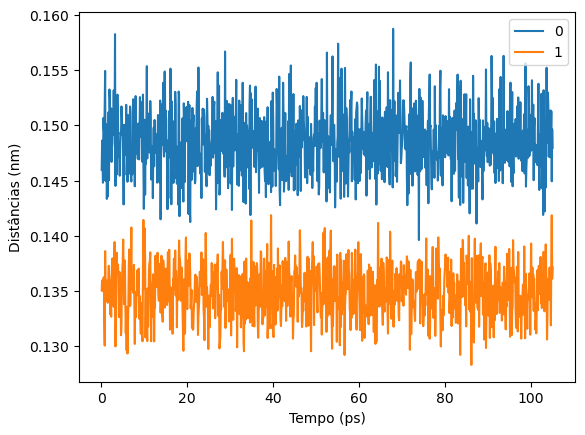

In [20]:
distances = mdtraj.compute_distances(traj, [[0, 1], [1, 2]])
print(distances.shape)
print(distances[400, 0])

fig, ax = plt.subplots(num="dist")
for counter, col in enumerate(distances.T):
    ax.plot(df["Time (ps)"], col, "-", label=str(counter))
ax.set_xlabel("Tempo (ps)")
ax.set_ylabel("Distâncias (nm)")
ax.legend(loc=0)

## Análise de Raio de Giração 

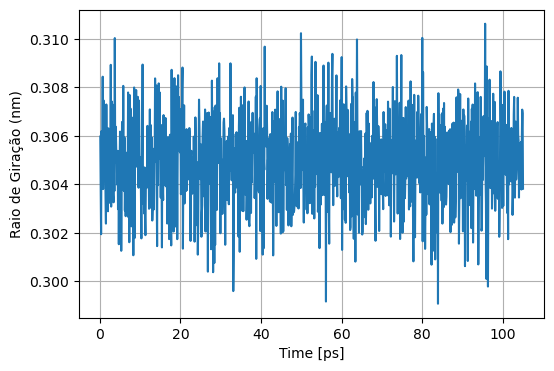

In [26]:
solute = traj.topology.select('not water')
rgyr = mdtraj.compute_rg(traj.atom_slice(solute))

plt.figure(figsize=(6, 4))
plt.plot(df['Time (ps)'],rgyr)
plt.xlabel("Time [ps]")
plt.ylabel('Raio de Giração (nm)')
plt.grid()

## Cálculo do Nº de Ligações de Hidrogênio

Text(0, 0.5, 'Potential energy [kJ/mol]')

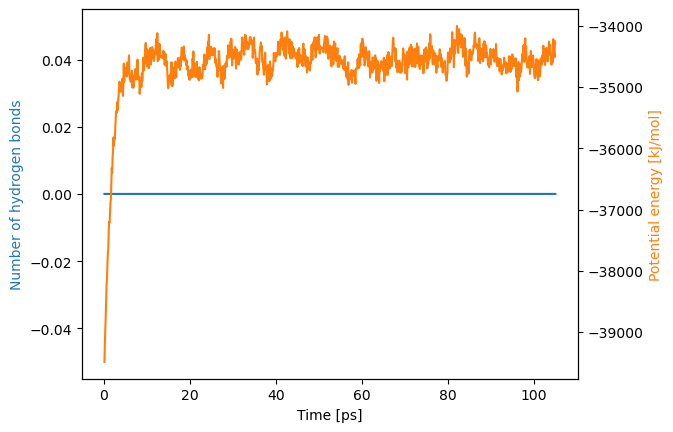

In [25]:
hbonds = mdtraj.wernet_nilsson(traj)
numhbonds = [len(pairs) for pairs in hbonds]

fig, ax1 = plt.subplots(num="numh")
ax1.plot(df['Time (ps)'],numhbonds, label="Num. HBonds")
ax1.set_xlabel("Time [ps]")
ax1.set_ylabel("Number of hydrogen bonds", color="C0")

ax2 = ax1.twinx()
ax2.plot(df['Time (ps)'], df["Potential Energy (kJ/mole)"], color="C1", label="Pot. Energy")
ax2.set_ylabel("Potential energy [kJ/mol]", color="C1")

**<span style="color:#A03;font-size:14pt">
&#x270B; HANDS-ON! &#x1F528;
</span>**

> Faça uma estimativa do custo computacional (tempo de simulação) no seu _hardware_ atual para simulações longas da ordem de 1ns. 
>